In [ ]:
import os
import folium
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap

folds  = 5

sns.set(color_codes=True)

warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

In [ ]:
# We will drop "date" and "id" because they are counter-productive for this example and not neccessary 

house_price_data = pd.read_csv("/content/kc_house_data.csv")
house_price_data = house_price_data.drop(["date","id"], axis = 1)

In [ ]:
house_price_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
# Now we'll add some new features to our house price data. When we actually look for a house, we keep all these features mentioned below in our mind:

* Age of house - Age of house extracted by choosing 2020 as a reference year.

* Is renovated(Categorical) - 1 for renovated condition, 0 otherwise
Total Area of house

* Basement(Categorical) - 1 if basement is available, 0 otherwise

In [ ]:
# Adding new features

house_price_data["Home_Age"] = 2020 - house_price_data["yr_built"]
house_price_data['is_renovated'] = house_price_data["yr_renovated"].where(house_price_data["yr_renovated"] == 0, 1)
house_price_data['Total_Area'] = house_price_data['sqft_living'] + house_price_data['sqft_lot'] + house_price_data['sqft_above'] + house_price_data['sqft_basement'] 
house_price_data['Basement'] = house_price_data['sqft_basement'].where(house_price_data["sqft_basement"] == 0, 1)

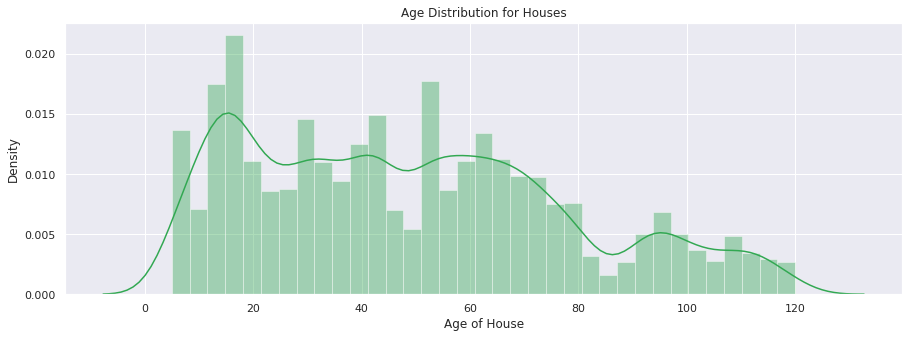

In [ ]:
# This is not a very big data and we do not have too many features. 
# Thus, we have chance to plot most of them and reach some useful analytical results. 
# Drawing charts and examining the data before applying a model is a very good practice because we may detect some possible outliers or decide to do normalization. 
# This is not a must but get know the data is always good.

# House Age Distribution 

plt.figure(figsize=(15,5))
sns.distplot(house_price_data["Home_Age"], color="#32a852")
plt.title("Age Distribution for Houses")
plt.ylabel("Density")
plt.xlabel("Age of House");

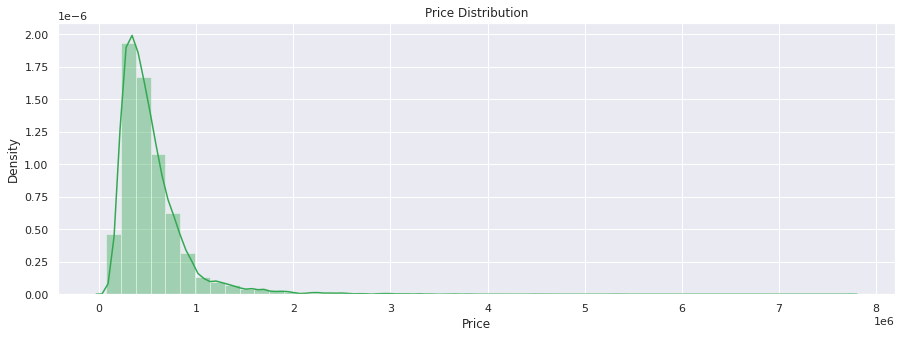

In [ ]:
# Price Distribution

plt.figure(figsize=(15,5))
sns.distplot(house_price_data["price"], color="#32a852")
plt.title("Price Distribution")
plt.ylabel("Density")
plt.xlabel("Price");
sns.set(color_codes=True)

In [ ]:
# Exploring correlation between features

plt.figure(figsize=(10,8))
cor = house_price_data.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Greens_r)
plt.show()

Above you can see there is a high correlation between Price and Area of house.

In [ ]:
# Distribution of all parameters wrt price.

nr_rows = 3
nr_cols = 6

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*4))

numerical_feats = house_price_data.dtypes[house_price_data.dtypes != "object"].index

li_num_feats = list(numerical_feats)
li_not_plot = ['id']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(house_price_data[li_plot_num_feats[i]], house_price_data['price'], ax = axs[r][c])
            stp = stats.pearsonr(house_price_data[li_plot_num_feats[i]], house_price_data['price'])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
sns.set(color_codes=True)
plt.show()   

In [ ]:
# Features having coorelation to price

sns.set(color_codes=True)
house_price_data.corrwith(house_price_data.price).plot.bar( figsize = (12, 5), title = "Correlation with respect to Prices", fontsize = 15, rot = 90, grid = True);

In [ ]:
# Visualizing the surrounding 

maxpr=house_price_data.loc[house_price_data['price'].idxmax()]

def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

house_price_data_copy = house_price_data.copy()
house_price_data_copy['count'] = 1
basemap = generateBaseMap()
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=house_price_data_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

In [ ]:
# Correlation wrt price

corr = house_price_data.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, 'price')['price']
print(ser_corr)

In [ ]:
# Conclusion:

# We see that for some features like 'sqft_living' and 'grade' there is a strong linear correlation of (0.70) and (0.67) to the target. 
# For this kernel I decided to use all features for prediction that have correlation with SalePrice. 
# In future work, we can try to drop some columns that have weak correlation with the target price. 
# Also, we can remove the outliers from the data for better model building practices.

In [ ]:
# Creating Data Split for training and testing purpose. 
# Also, using a scaled version of dataset for certain algorithms.

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

target = house_price_data["price"]
features = house_price_data.drop("price", axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.3, random_state = 1)

sc = StandardScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train))
X_test_sc = pd.DataFrame(sc.transform(X_test))

In [ ]:
# Using Grid Search Cross Validation for choosing the best parameters of models based on obtained scores.

def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

Scikit-learn offers a wide variety of regression algorithms. We'll build simple to complex regression models using different algorithms and will compare the results obtained over different models with our testing dataset which contains 30% of original dataset. For tuning the model and selecting optimum parameters. We'll use GridSearch cross validation.



*We test the following Regressors from scikit-learn:*

* LinearRegression
* Ridge
* Lasso
* Stochastic Gradient Descent
* DecisionTreeRegressor
* RandomForestRegressor
* KNN Regressor
* XGBoost Regressor

In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv = folds, verbose = 1 , scoring = score_calc)
grid_linear.fit(X_train, Y_train)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


193195.15010978153
{'copy_X': True, 'fit_intercept': False, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.8s finished


In [ ]:
LR = LinearRegression()
LR.fit(X_train, Y_train)
pred_linreg_all = LR.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [ ]:
# Rsquared Score for Linear Regression

r2_score(Y_test, pred_linreg_all)

0.6906907207314363

In [ ]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
grid_sgd = GridSearchCV(sgd, parameters, cv = folds, verbose = 0, scoring = score_calc)
grid_sgd.fit(X_train_sc, Y_train)

sc_sgd = get_best_score(grid_sgd)
pred_sgd = grid_sgd.predict(X_test_sc)

194458.65184220902
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.01,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=10000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)


In [ ]:
# Rsquared Score for SGD Regressor

r2_score(Y_test, pred_sgd)

0.6846992465329447

In [ ]:
from sklearn.tree import DecisionTreeRegressor

param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                'presort': [False,True] , 'random_state': [5] }

grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = folds, refit = True, verbose = 0, scoring = score_calc)
grid_dtree.fit(X_train, Y_train)

sc_dtree = get_best_score(grid_dtree)

pred_dtree = grid_dtree.predict(X_test)

In [ ]:
# Rsquared Score for DTree Regression

r2_score(Y_test, pred_dtree)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_rf.fit(X_train, Y_train)

sc_rf = get_best_score(grid_rf)
pred_rf = grid_rf.predict(X_test)

In [ ]:
# Rsquared Score for RandomForest

r2_score(Y_test, pred_rf)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,              
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_knn.fit(X_train_sc, Y_train)
sc_knn = get_best_score(grid_knn)
pred_knn = grid_knn.predict(X_test_sc)

In [ ]:
# Rsquared Score for KNN
r2_score(Y_test, pred_knn)

In [ ]:
from xgboost import XGBRegressor
param_grid = {'learning_rate' : [0.005,0.01,0.001], 'n_estimators' : [40,200], 'random_state': [5],
              'max_depth' : [4,9]}
grid_xgb = GridSearchCV(XGBRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_xgb.fit(X_train, Y_train)

sc_xgb = get_best_score(grid_xgb)
pred_xgb = grid_xgb.predict(X_test)

In [ ]:
# Rsquared Score for XGBoost Regressor

r2_score(Y_test, pred_xgb)

In [ ]:
# Linear Regression models gave up high RMSE. 
# XGB, KNN and Dtree models performed similarly with roughly 162.5k RMS error in estimation. 
# RandomForest recorded the lowest RMS error.

In [ ]:
list_scores = [sc_linear,sc_sgd, sc_dtree, sc_rf, sc_knn, sc_xgb]
list_predictions = [pred_linreg_all, pred_sgd, pred_dtree, pred_rf, pred_knn, pred_xgb]
list_regressors = ['Linear','SGD','DTr','RF','KNN','XGB']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE Training')
plt.show()

In [ ]:
list_scores = [sc_linear,sc_sgd, sc_dtree, sc_rf, sc_knn, sc_xgb]
list_predictions = [pred_linreg_all, pred_sgd, pred_dtree, pred_rf, pred_knn, pred_xgb]
list_regressors = ['Linear','SGD','DTr','RF','KNN','XGB']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE Training')
plt.show()

In [ ]:
# Let's compare the overall RMS error secured by models over the testing dataset. 
# RandomForest outformed all the models in the analysis and secured a rms value less than 150K 
# which means we can actually use the RandomForest model in estimating the house price given all the other features.

In [ ]:
errors = []
for pred in list_predictions:
    errors.append(rmse(Y_test, pred))
    
regressors = ['Linear','SGD','DTr','RF','KNN','XGB']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x = regressors, y = errors, ax=ax)
plt.ylabel('Actual Test RMSE')
plt.xlabel('Algorithms')
plt.show()

In [ ]:
predictions = {'Linear': pred_linreg_all,
               'SGD': pred_sgd, 'DTr': pred_dtree, 'RF': pred_rf,
               'KNN': pred_knn, 'XGB': pred_xgb}
df_predictions = pd.DataFrame(data=predictions) 

In [ ]:
# Only for Random Forest, Decision Tree and XGBoost, the results are less correlated with the other Regressors.

plt.figure(figsize=(10,8))
cor_pred = df_predictions.corr()
sns.heatmap(cor_pred, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# Conclusion

# We explored the data and added new features into it. 
# We did some EDA to visualize the impact of features over the traget price variable. 
# We built multiple regression models and evaluated their preformance over the test dataset. 
# RandomForest outformed other models and gave a RMSE slightly lower than 150k. 
# We compared correlation from different predicted estimates over the testing dataset. 